In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers, regularizers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dropout,Dense, BatchNormalization, Dropout, GlobalAveragePooling2D, Activation, SeparableConv2D
from tensorflow.keras.optimizers import Adam

In [ ]:
from os import path
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin = dataset_url, fname = 'flower_photos',cache_dir = '/content/', untar = True)
data_dir = pathlib.Path(data_dir)
print(data_dir)

228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step
/content/datasets/flower_photos


In [ ]:
# 전처리
from tensorflow.keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (120, 120)
BATCH_SIZE = 32
DATA_DIR = '/content/datasets/flower_photos/flower_photos/'

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 23,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.3,
    horizontal_flip = True,
    fill_mode = 'nearest',
    validation_split = 0.2,
    brightness_range = (0.8, 1.2)
    )

val_datagen = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.2
    )

train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'categorical', # 원-핫 인코딩 레이블
    shuffle = True,
    subset = 'training',
    seed = 42
    )

val_generator = val_datagen.flow_from_directory(
    DATA_DIR,
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle = False,
    subset = 'validation',
    seed = 42
    )

print("클래스:", train_generator.class_indices)

for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

Found 2939 images belonging to 5 classes.
Found 731 images belonging to 5 classes.
클래스: {'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}


((32, 120, 120, 3), (32, 5))

In [ ]:
l2_lambda = 1e-5

cnn = Sequential()

cnn.add(SeparableConv2D(24,(3,3), padding='same', input_shape = (100, 100, 3),
                        depthwise_regularizer = regularizers.l2(l2_lambda),
                        pointwise_regularizer=regularizers.l2(l2_lambda)))
cnn.add(BatchNormalization())
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D((2,2)))

cnn.add(SeparableConv2D(48,(3,3), padding='same',
                        depthwise_regularizer = regularizers.l2(l2_lambda),
                        pointwise_regularizer=regularizers.l2(l2_lambda)))
cnn.add(BatchNormalization())
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D((2,2)))

cnn.add(SeparableConv2D(96,(3,3), padding='same',
                        depthwise_regularizer = regularizers.l2(l2_lambda),
                        pointwise_regularizer=regularizers.l2(l2_lambda)))
cnn.add(BatchNormalization())
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D((2,2)))

cnn.add(GlobalAveragePooling2D())

cnn.add(Dense(5, activation = 'softmax',
              kernel_regularizer = regularizers.l2(l2_lambda)))

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=25, verbose=1, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1, min_lr=1e-6)

In [ ]:
optimizer = Adam(learning_rate = 0.00015)
cnn.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])
cnn.summary()

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ separable_conv2d_68             │ (None, 100, 100, 24)   │           123 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_65          │ (None, 100, 100, 24)   │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_65 (Activation)      │ (None, 100, 100, 24)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_65 (MaxPooling2D) │ (None, 50, 50, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_69             │ (None, 50, 50, 48)     │         1,416 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_66          │ (None, 50, 50, 48)     │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_66 (Activation)      │ (None, 50, 50, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_66 (MaxPooling2D) │ (None, 25, 25, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_70             │ (None, 25, 25, 96)     │         5,136 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_67          │ (None, 25, 25, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_67 (Activation)      │ (None, 25, 25, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_67 (MaxPooling2D) │ (None, 12, 12, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_21     │ (None, 96)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 5)              │           485 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,832 (30.59 KB)

 Trainable params: 7,496 (29.28 KB)

 Non-trainable params: 336 (1.31 KB)

In [ ]:
history = cnn.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    #steps_per_epoch=train_generator.samples // BATCH_SIZE,
    #validation_steps=val_generator.samples // BATCH_SIZE,
    #callbacks=[early_stopping, lr_scheduler] # 콜백 리스트
)

Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 27s 231ms/step - accuracy: 0.2226 - loss: 1.9941 - val_accuracy: 0.2175 - val_loss: 1.6104
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 188ms/step - accuracy: 0.3889 - loss: 1.4306 - val_accuracy: 0.2490 - val_loss: 1.6060
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 187ms/step - accuracy: 0.4525 - loss: 1.3276 - val_accuracy: 0.2517 - val_loss: 1.5954
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 187ms/step - accuracy: 0.5099 - loss: 1.2319 - val_accuracy: 0.2804 - val_loss: 1.5353
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 187ms/step - accuracy: 0.5307 - loss: 1.1920 - val_accuracy: 0.4036 - val_loss: 1.3736
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 188ms/step - accuracy: 0.5211 - loss: 1.1856 - val_accuracy: 0.5527 - val_loss: 1.2187
Epoch 7/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 187ms/step - accuracy: 0.5413 - loss: 1.1476 - val_accuracy: 0.5267 - val_loss: 1.1753
Epoch 8/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 187ms/step - accuracy: 0.5688 - loss: 1.1239 - 

In [ ]:
res = cnn.evaluate(val_generator)
print('정확도 = {:.3f}%'.format(res[1]*100))

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.6454 - loss: 1.0624
정확도 = 67.579%


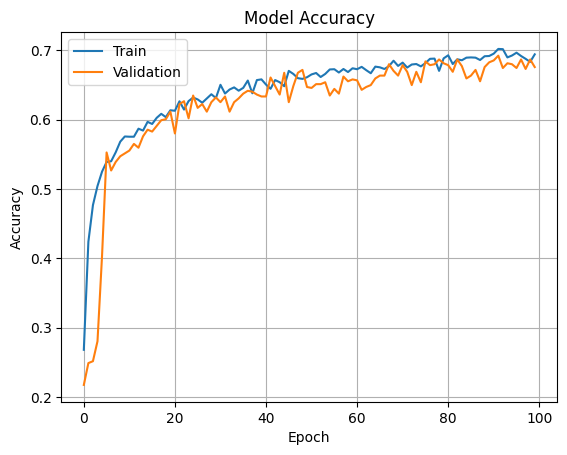

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.grid()
plt.show()

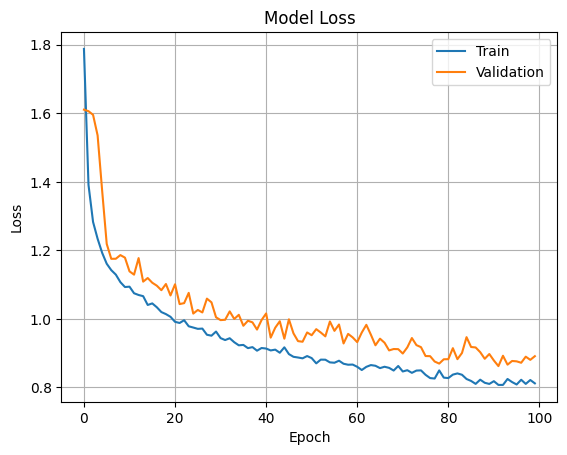

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.grid()
plt.show()

In [ ]:
# 훈련 데이터 개수 확인
num_train_samples = train_generator.samples
print(f"훈련 데이터 개수: {num_train_samples}")

# 검증 데이터 개수 확인 (또는 테스트 데이터 제너레이터를 만들었다면 해당 제너레이터 사용)
num_val_samples = val_generator.samples
print(f"검증 데이터 개수: {num_val_samples}")

# (선택 사항) 총 데이터 개수 확인 (두 개를 더하면 됨)
total_samples = num_train_samples + num_val_samples
print(f"총 데이터 개수: {total_samples}")

훈련 데이터 개수: 2939
검증 데이터 개수: 731
총 데이터 개수: 3670
